In [9]:
import os ; import sys ; sys.path.append('../dependencies/') ; import pandas as pd ; import numpy as np ; import matplotlib.pyplot as plt
import shutil ; import flopy ; from flopy.utils.gridgen import Gridgen  ; from flopy.utils.gridintersect import GridIntersect
import shapefile as sf ; from shapely.geometry import Polygon, LineString, MultiLineString, Point # print(f'Flopy version:{flopy.__version__}')
from pathlib import Path ; sim_ws =  Path("./02_out") ; sim_ws.mkdir(exist_ok=True)  
ref_data = os.path.join('01_out') ; ref_data2  ='E:\\15_REPOS\\00_data_intern\\Syymple\\sgn'

In [ ]:
%%capture
sim = flopy.mf6.MFSimulation.load(sim_ws=ref_data)         ; sim.set_sim_path(sim_ws) ; sim.write_simulation(silent=True)

In [6]:
gwf = sim.get_model("sgn") ; sim.tdis.perioddata.set_data([(1576800000., 4, 1.1)]) ; sim.tdis.perioddata ; print(sim.model_names)

['sgn']


In [7]:
sto =flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, steady_state=[True],filename="{}.sto".format(gwf.name))
name='sgn' ; gwtname = "gwt-" + name ; sconc = 0.0 ; scheme = "UPSTREAM" ; nouter, ninner = 100, 500 ; hclose, rclose, relax = 1e-6, 1e-6, 1.0
al = 30  ; ath1 = 3 ; atv = 3 ; dmcoef = 1.02E-9  ; prsity = 0.2 ; sourcerecarray = [()]#("CHD-1", "AUX", "CONCENTRATION")]

gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=gwtname,model_nam_file="{}.nam".format(gwtname),)            ; gwt.name_file.save_flows = True
imsgwt = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",inner_maximum=ninner,
                              inner_dvclose=hclose,rcloserecord=rclose,linear_acceleration="BICGSTAB",scaling_method="NONE",reordering_method="NONE",
                              relaxation_factor=relax,filename="{}.ims".format(gwtname),)
sim.register_ims_package(imsgwt, [gwt.name])
flopy.mf6.ModflowGwtdisv(gwt ,nlay=gwf.dis.nlay.get_data() ,ncpl=gwf.dis.ncpl.get_data() ,length_units=gwf.dis.length_units.get_data() ,top=gwf.dis.top.get_data() ,
                         botm=gwf.dis.botm.get_data() ,nvert=gwf.dis.nvert.get_data() ,vertices=gwf.dis.vertices.get_data() ,cell2d=gwf.dis.cell2d.get_data() ,
                         idomain=gwf.dis.idomain.get_data() ,filename="{}.dis".format(gwtname) ,)
flopy.mf6.ModflowGwtic  (gwt, strt=sconc, filename="{}.ic".format(gwtname))
flopy.mf6.ModflowGwtadv (gwt, scheme=scheme, filename="{}.adv".format(gwtname))
flopy.mf6.ModflowGwtdsp (gwt,alh=al,ath1=ath1,atv=atv,diffc=dmcoef,pname="DSP-1",filename="{}.dsp".format(gwtname),)
flopy.mf6.ModflowGwtmst (gwt,porosity=prsity,pname="MST-1",filename="{}.mst".format(gwtname),)
flopy.mf6.ModflowGwtssm (gwt,sources=sourcerecarray,print_flows=True,filename="{}.ssm".format(gwtname),)
flopy.mf6.ModflowGwtoc  (gwt,budget_filerecord="{}.cbc".format(gwtname),concentration_filerecord="{}.ucn".format(gwtname),
                         concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],saverecord=[("CONCENTRATION", "LAST"),("BUDGET", "LAST"),],
                         printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],filename="{}.oc".format(gwtname),)
flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea="sgn",exgmnameb=gwtname,filename="{}.gwfgwt".format(name),)

package_name = sgn.gwfgwt
filename = sgn.gwfgwt
package_type = gwfgwt
model_or_simulation_package = simulation
simulation_name = modflowsim


In [ ]:
ix = GridIntersect(gwf.modelgrid)
conc_shpfile = os.path.join(ref_data2, 'shp', 'real_unknown_sources.shp')  ; read_conc = sf.Reader(conc_shpfile) ; conc_shapes = read_conc.shapes()
conc_spd=[]
for i in range(len(conc_shapes)):
    shp = conc_shapes[i] ; record = read_conc.record(i) ; conc_i = record[-2] ; conc_site = record[-4] ; cellids = ix.intersect(shp).cellids
    for icpl in cellids:
        conc_spd.append(((0, icpl), conc_i, f'conc-{conc_site}'))
cnc = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=conc_spd, boundnames=True)

obs_shpfile = os.path.join(ref_data2, 'shp', 'Target_L1_sept2019_head_PCE.shp') ; obs_shapes = sf.Reader(obs_shpfile).shapes() ; obs_list=[]
for i in range(len(obs_shapes)):
    shp = obs_shapes[i]  ; cellids = ix.intersect(shp).cellids ; record = sf.Reader(obs_shpfile).record(i) ;     piezid = record[0]
    for icpl in cellids:
        obs_list.append((f'{piezid}', 'CONCENTRATION', (0, icpl))) # assume layer 1
obs_recarray = {'conc_obs.csv':obs_list}
obs_package = flopy.mf6.ModflowUtlobs(gwt, digits=10, print_input=True,continuous=obs_recarray)

In [ ]:
sim.write_simulation(silent=True) ; sim.run_simulation(silent=True)

In [16]:
fname = os.path.join(sim_ws, list(sim.model_names)[0] + '.hds') ; hdobj = flopy.utils.HeadFile(fname, model=gwf)
head = hdobj.get_alldata() ; hmin = head.min() ; hmax = head.max()
fname_mf6 = os.path.join(sim_ws, list(sim.model_names)[1] + ".ucn") ; ucnobj_mf6 = flopy.utils.HeadFile(fname_mf6, precision="double", text="CONCENTRATION")
times_mf6 = ucnobj_mf6.get_times() ; conc_mf6 = ucnobj_mf6.get_alldata()

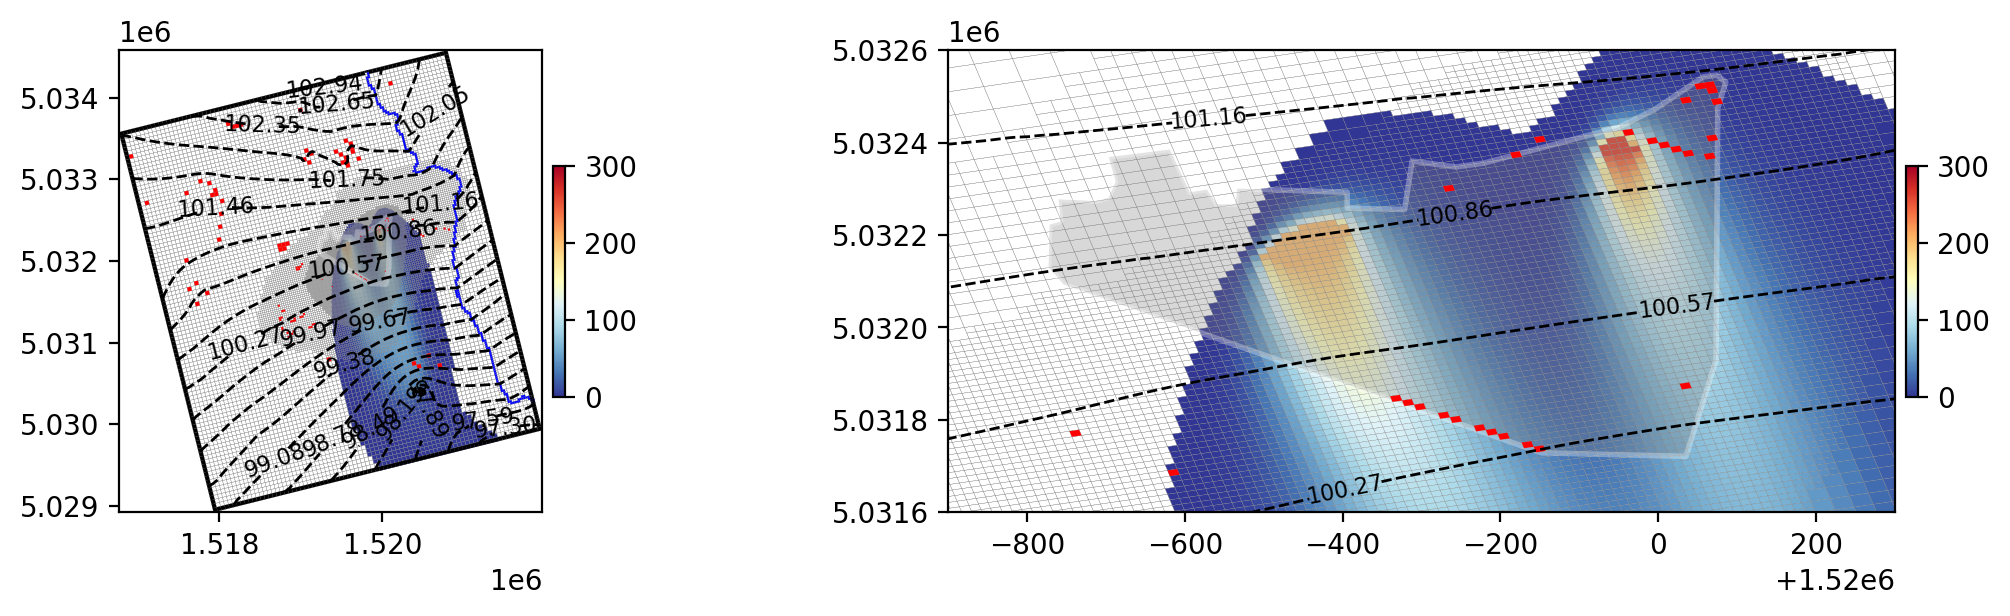

In [ ]:
fig = plt.figure(figsize=(15, 4), dpi=200)  
ax = fig.add_subplot(121, aspect='equal')
ext_offset = 500 ; extent=(1519100, 1520300, 5031600, 5032600) ; extent = gwf.modelgrid.extent 
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0, extent=extent) 
cint = (hmax-hmin)/20  ; levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
cs = mm.contour_array(head[0, 0, 0, :], colors='black', levels=levels, linestyles="--", linewidths=1)
plt.clabel(cs, fmt='%.2f', fontsize=8, inline=True) ; a = ucnobj_mf6.get_data(mflay=0)[0] ; a[a<0.1] = np.nan
ca = mm.plot_array(edgecolor='grey', a=a, cmap='RdYlBu_r',   alpha=1, linewidth=0.1, vmin=0, vmax=300) ; cb = plt.colorbar(ca, shrink=0.5, pad=0.01, )
flopy.plot.plot_shapefile(sf.Reader(os.path.join(ref_data2, 'shp','Site_area.shp')), linewidth=2, facecolor='grey', edgecolor='w', alpha=0.3);
wells = mm.plot_bc("WEL") ; riv=mm.plot_bc("RIV", color="blue") ; riv = mm.plot_bc("GHB", color = 'black')
ax = fig.add_subplot(122) 
ext_offset = 500 ; extent=(1519100, 1520300, 5031600, 5032600) 
mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0, extent=extent) 
cint = (hmax-hmin)/20  ; levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
cs = mm.contour_array(head[0, 0, 0, :], colors='black', levels=levels, linestyles="--", linewidths=1)
plt.clabel(cs, fmt='%.2f', fontsize=8, inline=True) ; a = ucnobj_mf6.get_data(mflay=0)[0] ; a[a<0.1] = np.nan
ca = mm.plot_array(edgecolor='grey', a=a, cmap='RdYlBu_r',   alpha=1, linewidth=0.1, vmin=0, vmax=300) ; cb = plt.colorbar(ca, shrink=0.5, pad=0.01, )
flopy.plot.plot_shapefile(sf.Reader(os.path.join(ref_data2, 'shp','Site_area.shp')), linewidth=2, facecolor='grey', edgecolor='w', alpha=0.3);
wells = mm.plot_bc("WEL") ; riv=mm.plot_bc("RIV", color="blue") ; riv = mm.plot_bc("GHB", color = 'black')
plt.show()